In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

### Methods

In [2]:
def plot_class_distribution(y, title='Class Distribution'):
    """Plot the distribution of classes in the target variable."""
    plt.figure(figsize=(10, 5))
    sns.countplot(x=y)
    plt.title(title)
    plt.show()

In [3]:

def create_resampling_pipeline(smote_ratio=0.5, undersample_ratio=0.7, random_state=42):
    """Create a resampling pipeline with SMOTE and RandomUnderSampler."""
    return Pipeline([
        ('smote', SMOTE(sampling_strategy=smote_ratio, random_state=random_state)),
        ('undersampling', RandomUnderSampler(sampling_strategy=undersample_ratio, random_state=random_state))
    ])

In [4]:

def prepare_training_data(X, y, test_size=0.2, random_state=42):
    """Prepare and resample training data."""
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=y
    )
    
    # Convert to dense format if using sparse matrices
    if hasattr(X_train, 'toarray'):
        X_train = X_train.toarray()
        X_test = X_test.toarray()
    
    # Apply resampling
    resampling = create_resampling_pipeline()
    X_train_resampled, y_train_resampled = resampling.fit_resample(X_train, y_train)
    
    return X_train_resampled, X_test, y_train_resampled, y_test


In [5]:

def get_default_xgb_params(y_train):
    """Get default XGBoost parameters."""
    return {
        'objective': 'binary:logistic',
        'eval_metric': ['logloss', 'error', 'auc'],
        'max_depth': 6,
        'min_child_weight': 1,
        'learning_rate': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1),
        'tree_method': 'hist'
    }


In [25]:
def train_xgboost_model(X_train, X_test, y_train, y_test, params=None, num_rounds=1000):
    """Train XGBoost model with early stopping and return evaluation results."""
    # Create DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # Use default params if none provided
    if params is None:
        params = get_default_xgb_params(y_train)
    
    # Create evaluation list
    evals = [(dtrain, 'train'), (dtest, 'eval')]
    
    # Initialize dictionary to store evaluation results
    evals_result = {}
    
    # Train model
    model = xgb.train(
        params,
        dtrain,
        num_rounds,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=100,
        evals_result=evals_result
    )
    
    return model, evals_result

In [26]:
def plot_training_metrics(evals_result):
    """Plot training metrics including loss, error, and AUC."""
    plt.figure(figsize=(15, 5))
    
    # Plot training and validation log loss
    plt.subplot(1, 3, 1)
    plt.plot(evals_result['train']['logloss'], label='Train')
    plt.plot(evals_result['eval']['logloss'], label='Validation')
    plt.title('Log Loss vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.legend()
    
    # Plot training and validation error
    plt.subplot(1, 3, 2)
    plt.plot(evals_result['train']['error'], label='Train')
    plt.plot(evals_result['eval']['error'], label='Validation')
    plt.title('Classification Error vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Error')
    plt.legend()
    
    # Plot training and validation AUC
    plt.subplot(1, 3, 3)
    plt.plot(evals_result['train']['auc'], label='Train')
    plt.plot(evals_result['eval']['auc'], label='Validation')
    plt.title('AUC vs Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Convert evaluation results to DataFrame for saving
    results = pd.DataFrame({
        'train-logloss': evals_result['train']['logloss'],
        'eval-logloss': evals_result['eval']['logloss'],
        'train-error': evals_result['train']['error'],
        'eval-error': evals_result['eval']['error'],
        'train-auc': evals_result['train']['auc'],
        'eval-auc': evals_result['eval']['auc']
    })
    
    return results


In [8]:

def evaluate_model(model, X_test, y_test):
    """Evaluate the model and plot confusion matrix and ROC curve."""
    dtest = xgb.DMatrix(X_test)
    y_pred_proba = model.predict(dtest)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    return y_pred, y_pred_proba


In [9]:

def plot_feature_importance(model, feature_names=None, top_n=20):
    """Plot feature importance analysis."""
    feature_importance = model.get_score(importance_type='gain')
    importance_df = pd.DataFrame.from_dict(feature_importance, orient='index', columns=['importance'])
    
    if feature_names is not None:
        importance_df.index = feature_names
    
    importance_df = importance_df.sort_values('importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(12, 6))
    importance_df['importance'].plot(kind='bar')
    plt.title(f'Top {top_n} Most Important Features')
    plt.xlabel('Features')
    plt.ylabel('Importance Score (Gain)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return importance_df


In [10]:

def run_cross_validation(X_train, y_train, params=None, num_rounds=None):
    """Run cross-validation for robustness check."""
    dtrain = xgb.DMatrix(X_train, label=y_train)
    
    if params is None:
        params = get_default_xgb_params(y_train)
    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_rounds if num_rounds else 1000,
        nfold=5,
        early_stopping_rounds=50,
        metrics=['auc', 'error'],
        seed=42
    )
    
    print("\nCross-validation results:")
    print(cv_results.tail())
    
    return cv_results


In [27]:
def train_and_evaluate(X, y, feature_names=None, custom_params=None):
    """Main function to train and evaluate the model."""
    # Plot initial class distribution
    plot_class_distribution(y, title='Initial Class Distribution')
    
    # Prepare data
    X_train_resampled, X_test, y_train_resampled, y_test = prepare_training_data(X, y)
    
    # Plot resampled class distribution
    plot_class_distribution(y_train_resampled, title='Class Distribution After Resampling')
    
    # Train model
    model, evals_result = train_xgboost_model(
        X_train_resampled, 
        X_test, 
        y_train_resampled, 
        y_test, 
        params=custom_params
    )
    
    # Plot training metrics
    results = plot_training_metrics(evals_result)
    
    # Evaluate model
    y_pred, y_pred_proba = evaluate_model(model, X_test, y_test)
    
    # Plot feature importance
    # importance_df = plot_feature_importance(model, feature_names)
    
    # Run cross-validation
    # cv_results = run_cross_validation(
    #     X_train_resampled, 
    #     y_train_resampled, 
    #     params=custom_params, 
    #     num_rounds=model.best_ntree_limit
    # )
    
    # # Save artifacts
    # model.save_model('xgboost_model.json')
    # cv_results.to_csv('cv_results.csv')
    # results.to_csv('training_results.csv')
    
    return model, results

### Run the code

In [13]:
df = pd.read_csv('../data/processed/labelled_data.csv')
df[['review_text', 'spacy_tokens', 'ground_truth']].head()

,review_text,spacy_tokens,ground_truth
0,good service ayu friendly staff samadhi accomm...,"['good', 'service', 'ayu', 'friendly', 'staff'...",positive
1,change r lady manager r hotel morning shift us...,"['change', 'r', 'lady', 'manager', 'r', 'hotel...",negative
2,perfect liked everything staff kind food good ...,"['perfect', 'liked', 'everything', 'staff', 'k...",positive
3,stay unforgettable hotel beautiful staff reall...,"['stay', 'unforgettable', 'hotel', 'beautiful'...",positive
4,amazing hotel well situated colombo directly h...,"['amazing', 'hotel', 'well', 'situated', 'colo...",positive


In [14]:
# encode target
df['sentiment'] = df['ground_truth'].map({'positive': 1, 'negative': 0})
df['sentiment'].value_counts()

sentiment
1    11227
0      581
Name: count, dtype: int64

In [17]:
y = df['sentiment']

#### Count Vectors

In [19]:
# Count Vectorizer
count_vectorizer = CountVectorizer(max_features=3000, min_df=5, max_df=0.8)
X_count = count_vectorizer.fit_transform(df['spacy_tokens'])  # Transform text into sparse matrix

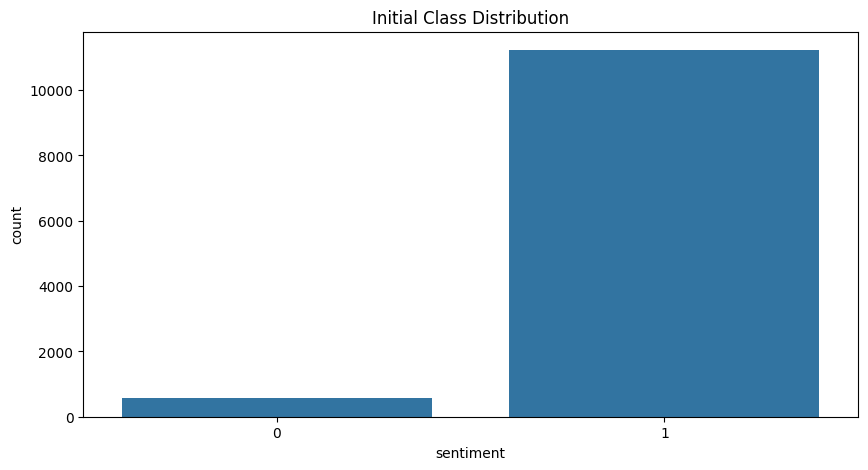

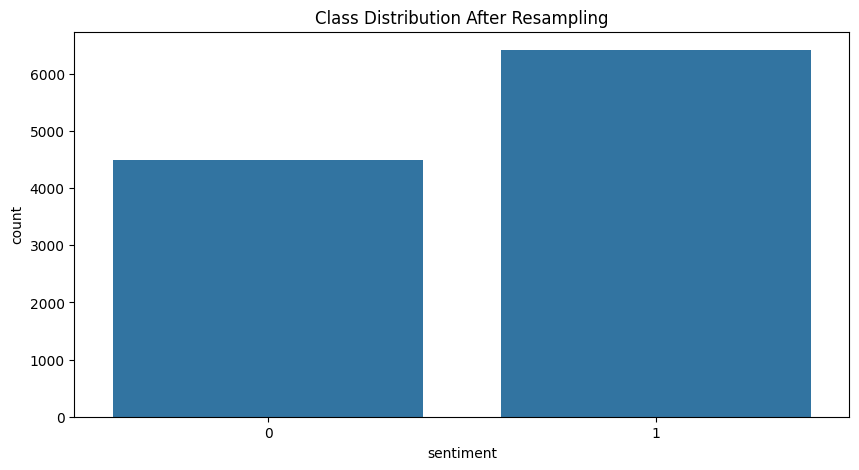

[0]	train-logloss:0.63244	train-error:0.11445	train-auc:0.91545	eval-logloss:0.63566	eval-error:0.15453	eval-auc:0.85054
[100]	train-logloss:0.06394	train-error:0.01733	train-auc:0.99889	eval-logloss:0.10298	eval-error:0.03980	eval-auc:0.97748
[200]	train-logloss:0.03455	train-error:0.00835	train-auc:0.99975	eval-logloss:0.08371	eval-error:0.03472	eval-auc:0.98089
[300]	train-logloss:0.02287	train-error:0.00449	train-auc:0.99994	eval-logloss:0.07921	eval-error:0.03387	eval-auc:0.98169
[304]	train-logloss:0.02256	train-error:0.00440	train-auc:0.99994	eval-logloss:0.07900	eval-error:0.03387	eval-auc:0.98192


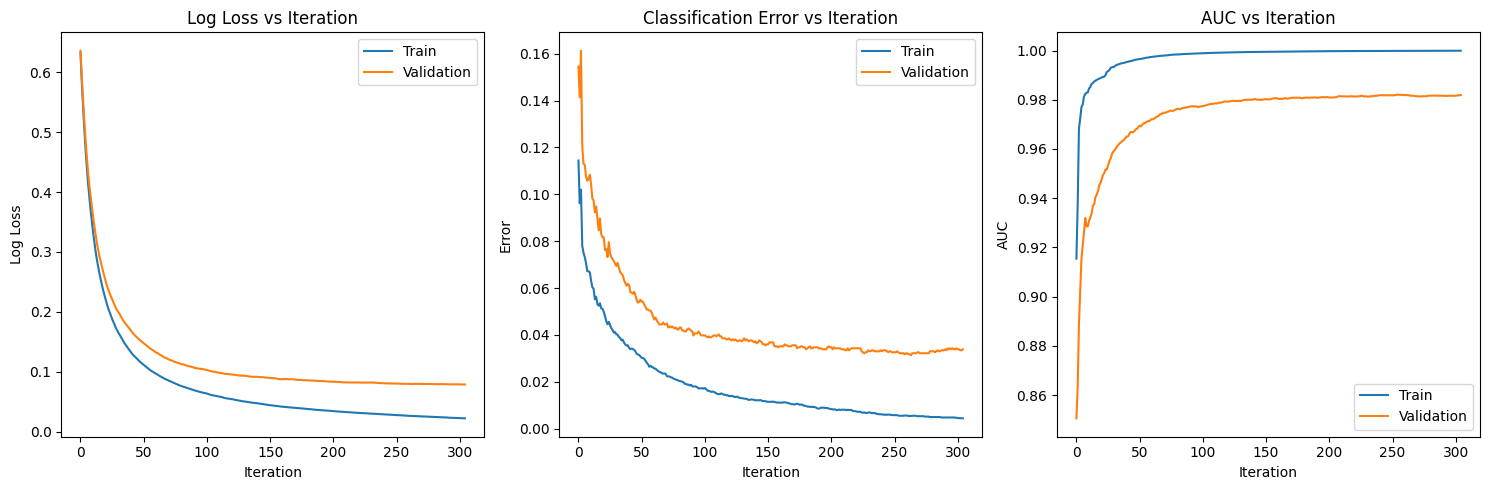

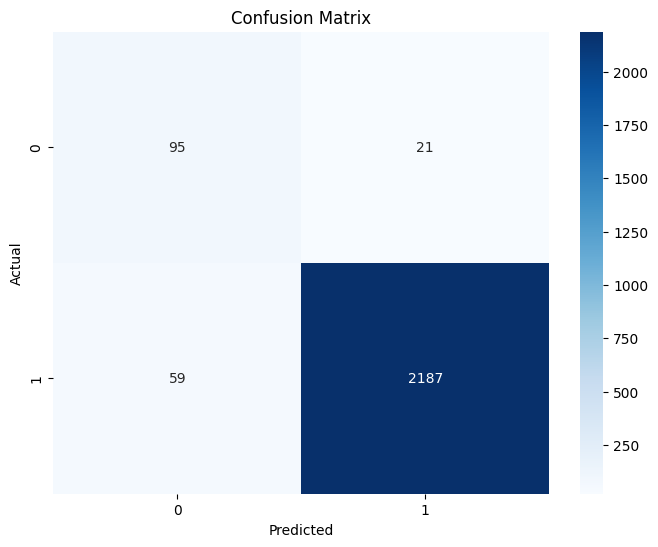

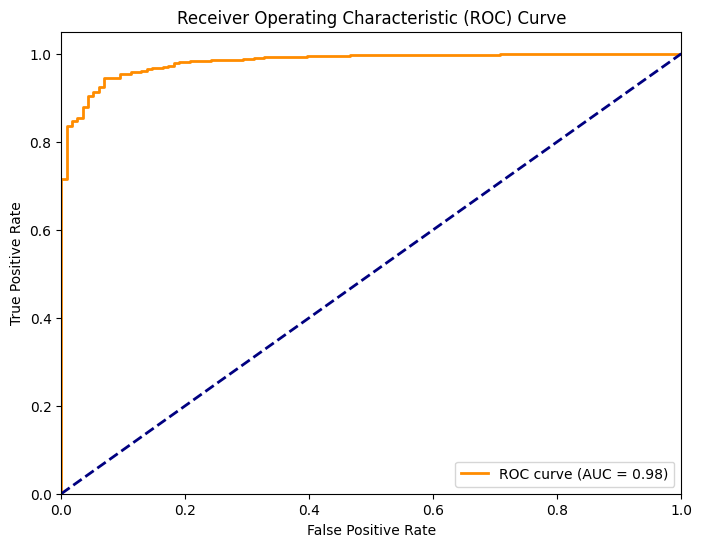


Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.82      0.70       116
           1       0.99      0.97      0.98      2246

    accuracy                           0.97      2362
   macro avg       0.80      0.90      0.84      2362
weighted avg       0.97      0.97      0.97      2362



In [29]:
model_count, results_count = train_and_evaluate(
    X_count, 
    y,
    feature_names=count_vectorizer.get_feature_names_out()
)

#### TF-IDF

In [30]:
tfidf_vectorizer = TfidfVectorizer(max_features=3000,min_df=5, max_df=0.8)
X_tfidf = tfidf_vectorizer.fit_transform(df['review_text'])

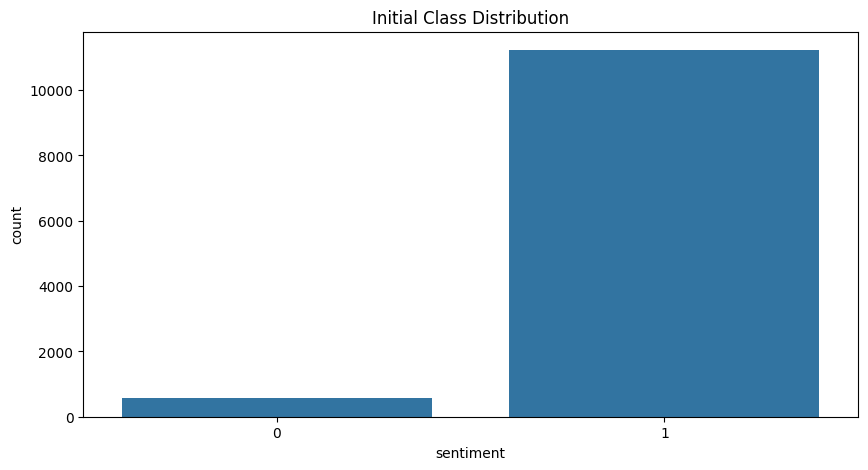

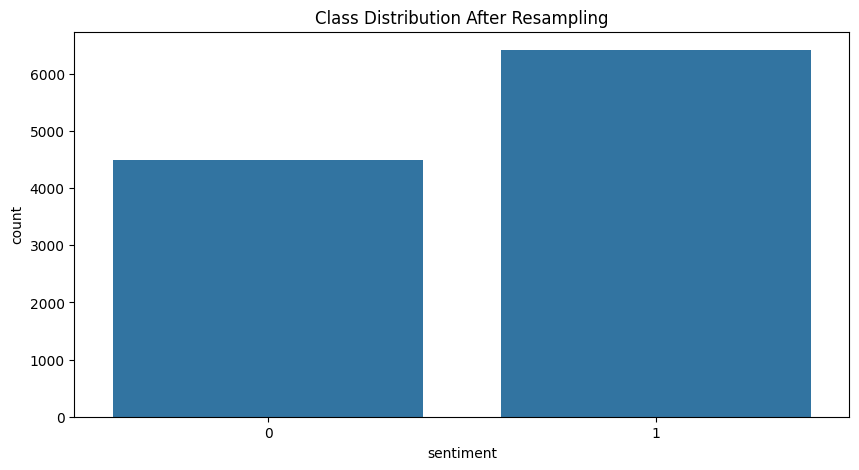

[0]	train-logloss:0.62609	train-error:0.07529	train-auc:0.92893	eval-logloss:0.62937	eval-error:0.06478	eval-auc:0.79856
[100]	train-logloss:0.03765	train-error:0.00734	train-auc:0.99978	eval-logloss:0.09372	eval-error:0.03429	eval-auc:0.97724
[200]	train-logloss:0.01603	train-error:0.00092	train-auc:1.00000	eval-logloss:0.07832	eval-error:0.03048	eval-auc:0.98189
[300]	train-logloss:0.00923	train-error:0.00000	train-auc:1.00000	eval-logloss:0.07501	eval-error:0.03048	eval-auc:0.98318
[380]	train-logloss:0.00652	train-error:0.00000	train-auc:1.00000	eval-logloss:0.07506	eval-error:0.02964	eval-auc:0.98333


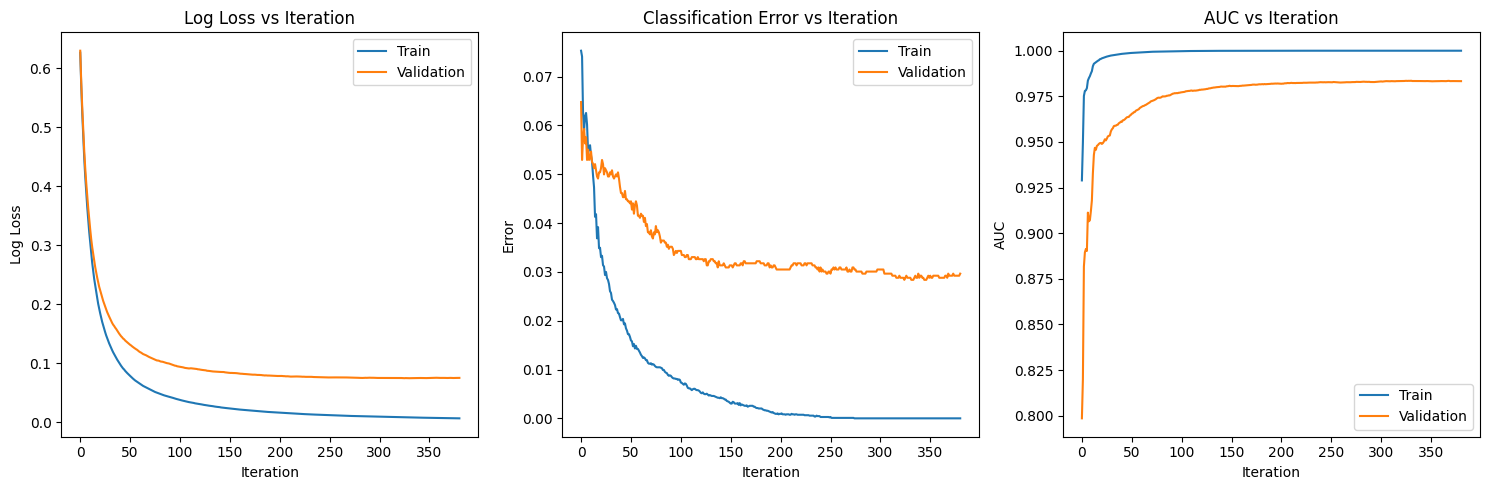

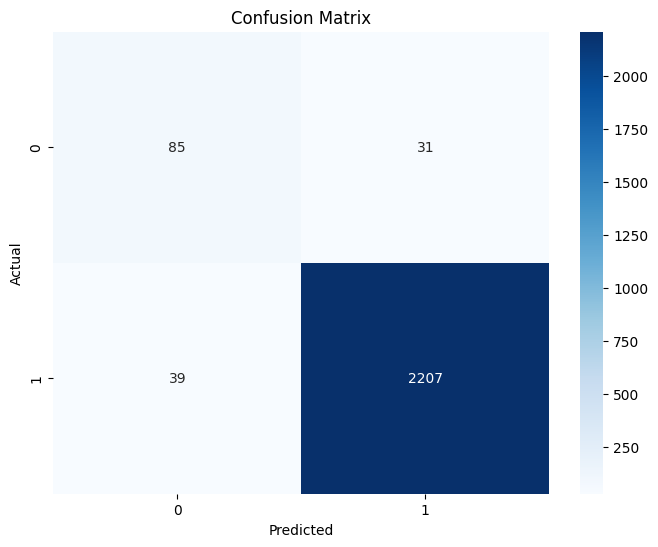

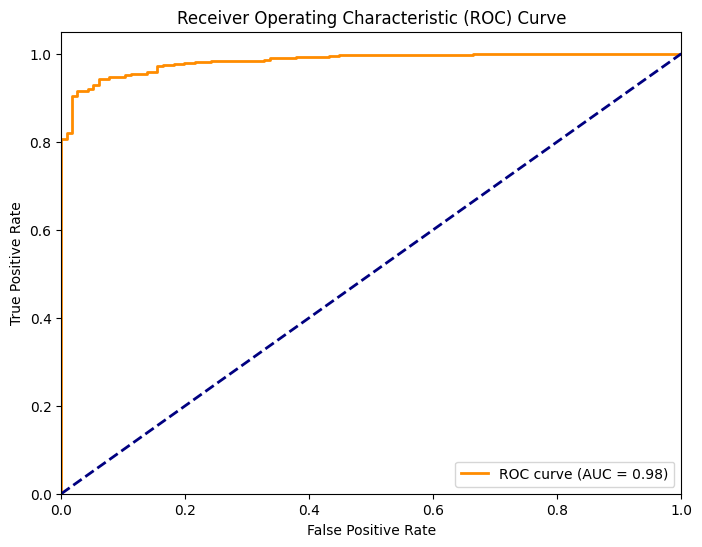


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       116
           1       0.99      0.98      0.98      2246

    accuracy                           0.97      2362
   macro avg       0.84      0.86      0.85      2362
weighted avg       0.97      0.97      0.97      2362



In [31]:
model_tfidf, results_tfidf = train_and_evaluate(
    X_tfidf, 
    y,
    feature_names=tfidf_vectorizer.get_feature_names_out()
)

#### Glove

In [33]:
X_glove = np.load('../data/processed/vector_representations/glove_embedding_matrix.npy')

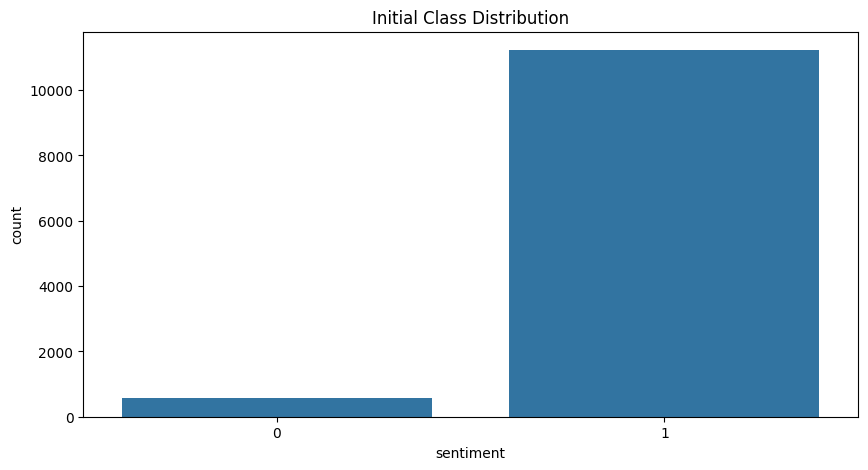

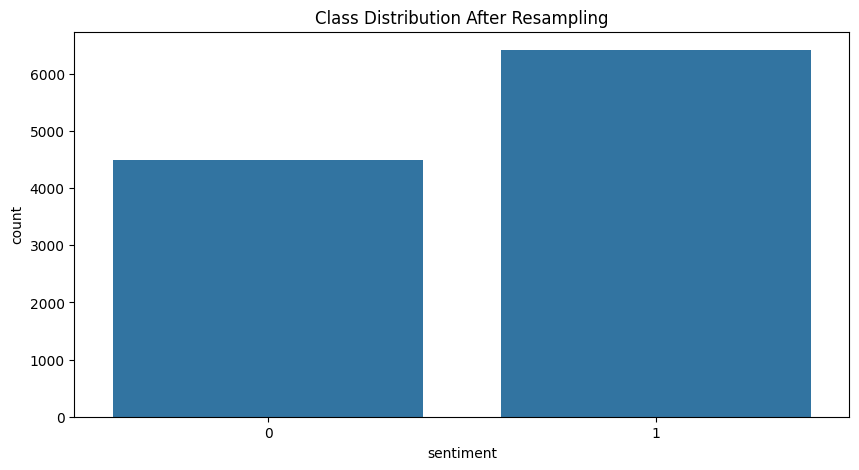

[0]	train-logloss:0.62609	train-error:0.07529	train-auc:0.92893	eval-logloss:0.62937	eval-error:0.06478	eval-auc:0.79856
[100]	train-logloss:0.03765	train-error:0.00734	train-auc:0.99978	eval-logloss:0.09372	eval-error:0.03429	eval-auc:0.97724
[200]	train-logloss:0.01603	train-error:0.00092	train-auc:1.00000	eval-logloss:0.07832	eval-error:0.03048	eval-auc:0.98189
[300]	train-logloss:0.00923	train-error:0.00000	train-auc:1.00000	eval-logloss:0.07501	eval-error:0.03048	eval-auc:0.98318
[380]	train-logloss:0.00652	train-error:0.00000	train-auc:1.00000	eval-logloss:0.07506	eval-error:0.02964	eval-auc:0.98333


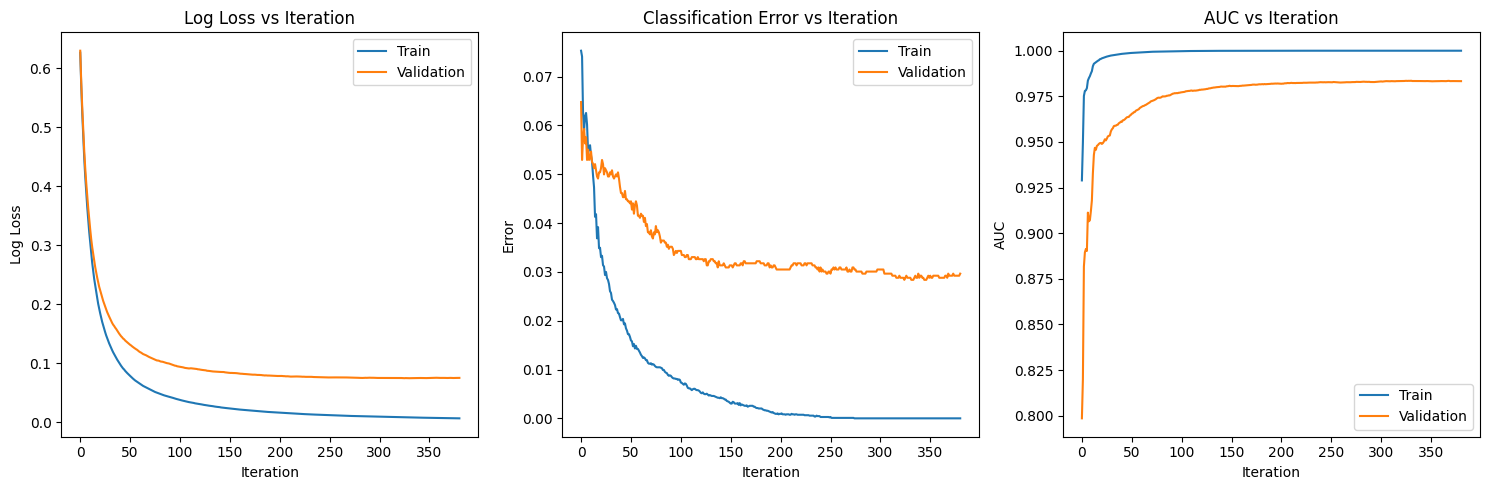

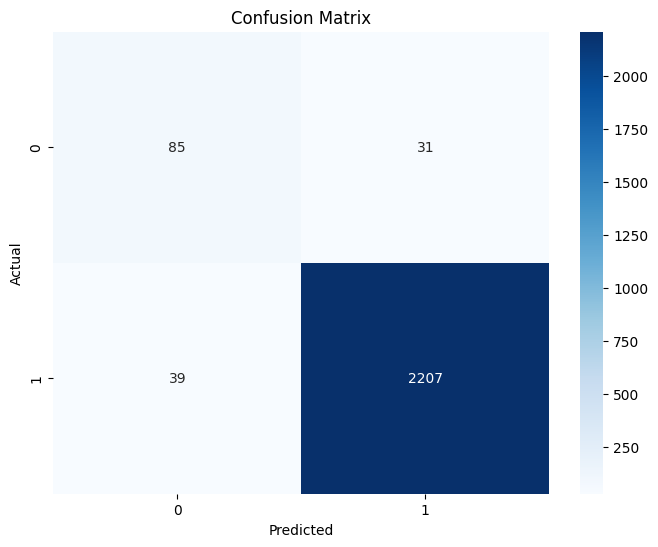

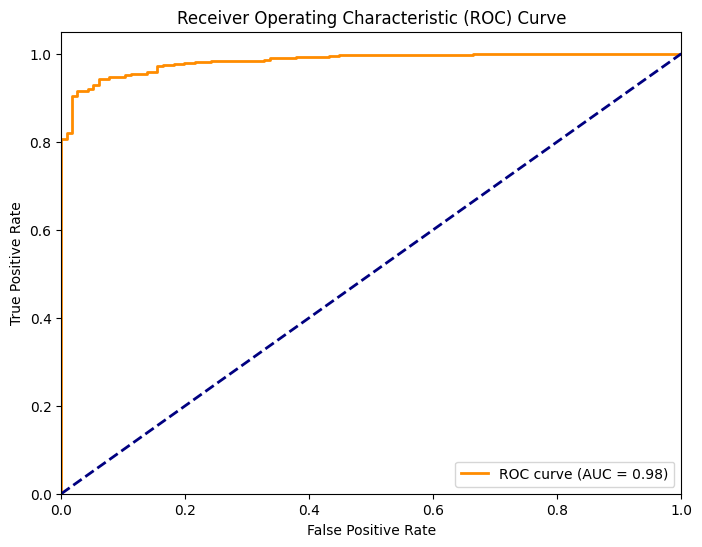


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.73      0.71       116
           1       0.99      0.98      0.98      2246

    accuracy                           0.97      2362
   macro avg       0.84      0.86      0.85      2362
weighted avg       0.97      0.97      0.97      2362



In [ ]:
model_tfidf, results_tfidf = train_and_evaluate(
    X_glove, 
    y,
)